In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
import shutil
from tqdm import tqdm
import random
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [5]:
import tarfile

tar_file_path = 'static-methods-impact.tar'

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(path='.')
    print("Extraction complete!")


Extraction complete!


## Is there correlation between amount of static methods and cyclomatic complexity of a class?

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

cc_df = pd.read_csv("dataset/data/CC.csv")
stat_df = pd.read_csv("dataset/data/STAT.csv")

merged_df = cc_df.merge(stat_df, on=['repo', 'java_file'], how='inner')

merged_df.dropna(inplace=True)


### Distribution of static methods and cyclomatic complexity

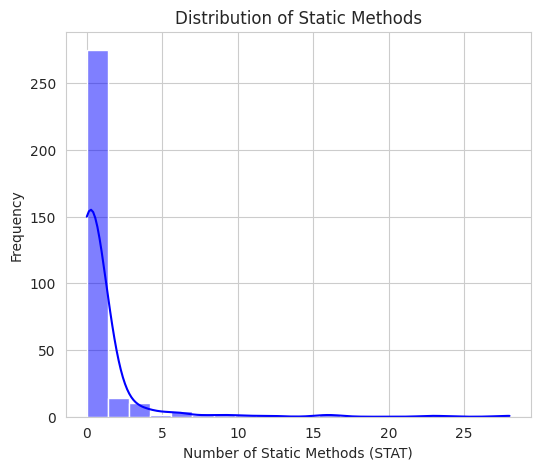

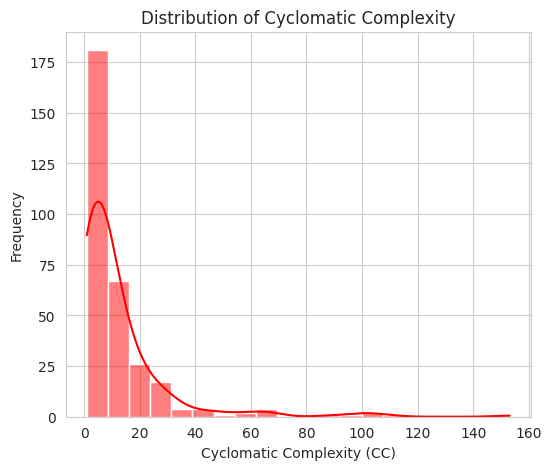

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(6, 5))
sns.histplot(merged_df['STAT'], bins=20, kde=True, color='blue')
plt.xlabel("Number of Static Methods (STAT)")
plt.ylabel("Frequency")
plt.title("Distribution of Static Methods")
plt.show()

plt.figure(figsize=(6, 5))
sns.histplot(merged_df['CC'], bins=20, kde=True, color='red')
plt.xlabel("Cyclomatic Complexity (CC)")
plt.ylabel("Frequency")
plt.title("Distribution of Cyclomatic Complexity")
plt.show()


As we can see, our data follows log-normal distribution, so we cannot apply Pearsons correlation. We will use Spearmans correlation instead


### Boxplots of our data

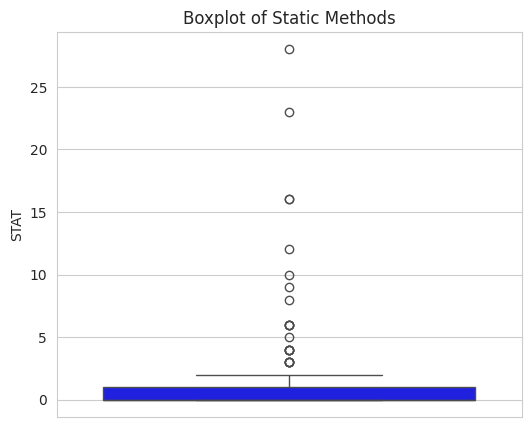

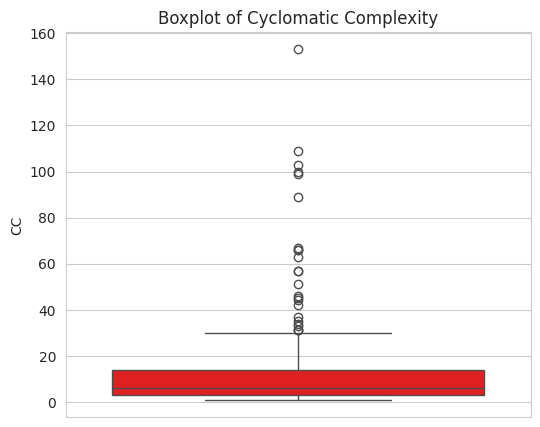

In [33]:
plt.figure(figsize=(6, 5))
sns.boxplot(y=merged_df['STAT'], color='blue')
plt.title("Boxplot of Static Methods")
plt.show()

plt.figure(figsize=(6, 5))
sns.boxplot(y=merged_df['CC'], color='red')
plt.title("Boxplot of Cyclomatic Complexity")
plt.show()


### Spearman correlation coefficients

Spearman correlation: 0.5591, p-value: 0.0000


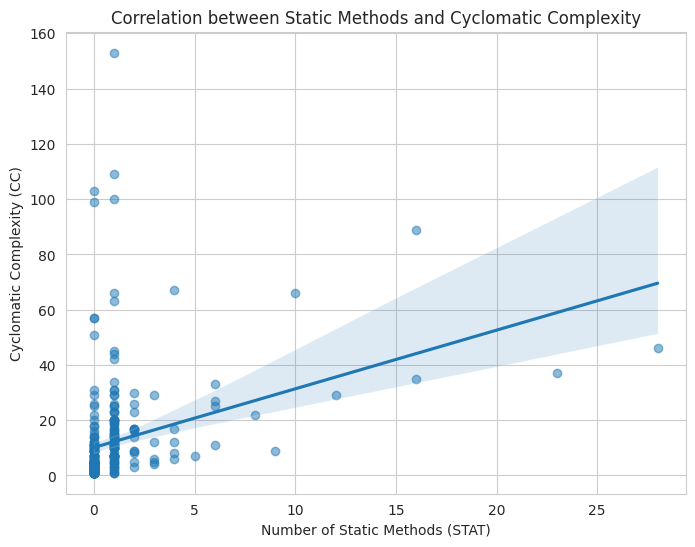

In [34]:
corr, p_value = spearmanr(merged_df['STAT'], merged_df['CC'])
print(f"Spearman correlation: {corr:.4f}, p-value: {p_value:.4f}")

plt.figure(figsize=(8, 6))
sns.regplot(x=merged_df['STAT'], y=merged_df['CC'], scatter_kws={'alpha': 0.5})
plt.xlabel("Number of Static Methods (STAT)")
plt.ylabel("Cyclomatic Complexity (CC)")
plt.title("Correlation between Static Methods and Cyclomatic Complexity")
plt.show()

Our data follows log-normal distribution, so Log-normal regression is more suitable

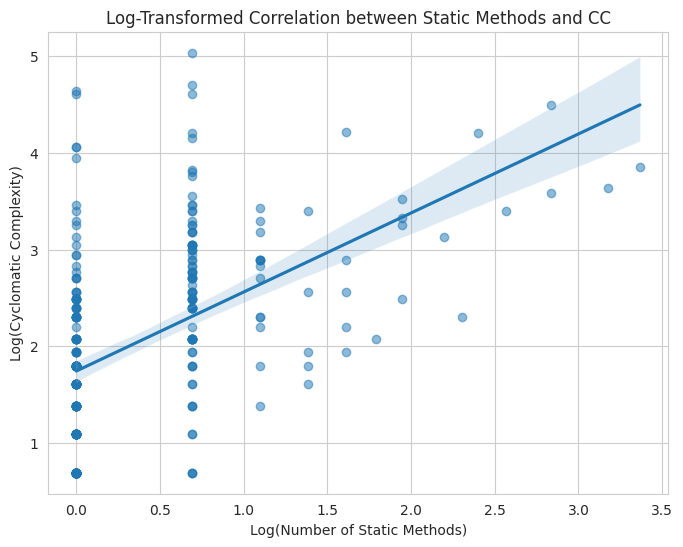

In [35]:
import numpy as np

merged_df['log_STAT'] = np.log1p(merged_df['STAT'])
merged_df['log_CC'] = np.log1p(merged_df['CC'])

plt.figure(figsize=(8, 6))
sns.regplot(x=merged_df['log_STAT'], y=merged_df['log_CC'], scatter_kws={'alpha': 0.5})
plt.xlabel("Log(Number of Static Methods)")
plt.ylabel("Log(Cyclomatic Complexity)")
plt.title("Log-Transformed Correlation between Static Methods and CC")
plt.show()

From our findings, we may conclude that there is a strong correlation between amount of static methods and cyclomatic complexity

## Do static methods have generally greater cyclomatic complexity than existing ones?

We'll use methods_aggregated.csv, which has isStatic and cyclomaticComplexity per method.


In [36]:
import pandas as pd

methods_df = pd.read_csv("dataset/data/methods_aggregated.csv")
methods_df = methods_df[['isStatic', 'cyclomaticComplexity']]
methods_df.dropna(inplace=True)
methods_df['isStatic'] = methods_df['isStatic'].apply(lambda x: x == 'static')
print(methods_df.groupby('isStatic')['cyclomaticComplexity'].describe())


           count      mean       std  min  25%  50%  75%   max
isStatic                                                      
False     4474.0  1.747430  2.098118  1.0  1.0  1.0  1.0  30.0
True       818.0  2.759169  2.885738  1.0  1.0  2.0  3.0  27.0


### Distribution of our data

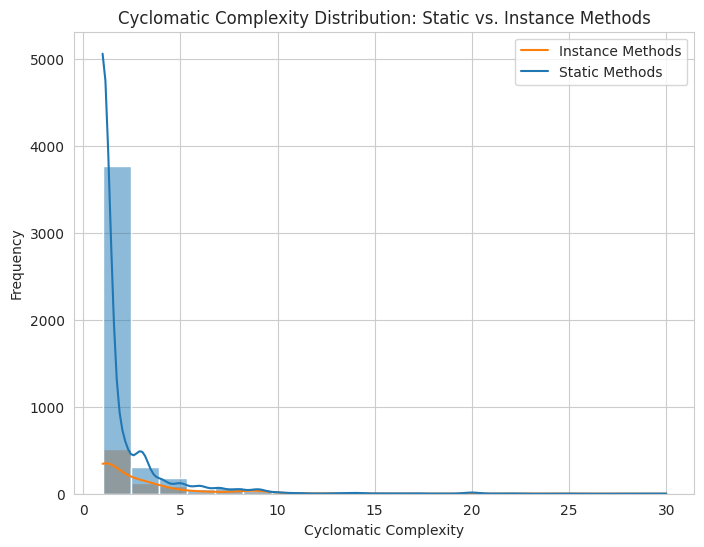

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(data=methods_df, x='cyclomaticComplexity', hue='isStatic', bins=20, kde=True, alpha=0.5)
plt.xlabel("Cyclomatic Complexity")
plt.ylabel("Frequency")
plt.title("Cyclomatic Complexity Distribution: Static vs. Instance Methods")
plt.legend(["Instance Methods", "Static Methods"])
plt.show()


### Boxplots of our data

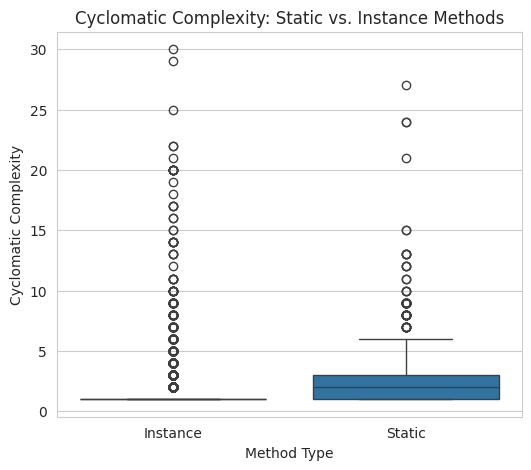

In [38]:
plt.figure(figsize=(6, 5))
sns.boxplot(x=methods_df['isStatic'], y=methods_df['cyclomaticComplexity'])
plt.xticks([0, 1], ['Instance', 'Static'])
plt.xlabel("Method Type")
plt.ylabel("Cyclomatic Complexity")
plt.title("Cyclomatic Complexity: Static vs. Instance Methods")
plt.show()


Our data is not normally distributed, so we can't use T-test. Mann-Whitney U Test is more suitable for our case

In [39]:
from scipy.stats import mannwhitneyu

# Separate CC values for static and instance methods
cc_static = methods_df[methods_df['isStatic']]['cyclomaticComplexity']
cc_instance = methods_df[~methods_df['isStatic']]['cyclomaticComplexity']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(cc_static, cc_instance, alternative='greater')
print(f"Mann-Whitney U Test: U={stat}, p-value={p_value:.4f}")


Mann-Whitney U Test: U=2355870.0, p-value=0.0000


From our findings, we can conclude that static methods generally have greater Cyclomatic Complexity

## Is there correlation between size of a class in lines of code and amount of static methods it contains?

In [40]:
import pandas as pd

loc_df = pd.read_csv("dataset/data/LoC.csv")
stat_df = pd.read_csv("dataset/data/STAT.csv")
merged_df = loc_df.merge(stat_df, on=['repo', 'java_file'], how='inner')
merged_df.dropna(inplace=True)


Distribution of data

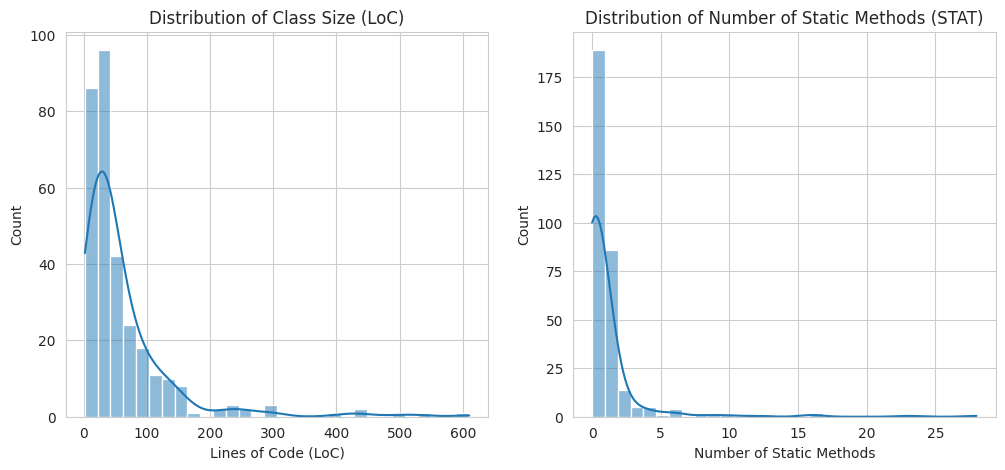

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distributions for LoC and STAT
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(merged_df['LoC'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Class Size (LoC)")
axes[0].set_xlabel("Lines of Code (LoC)")

sns.histplot(merged_df['STAT'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Number of Static Methods (STAT)")
axes[1].set_xlabel("Number of Static Methods")

plt.show()


As we can see, our data follows log-normal distribution, so we cannot apply Pearsons correlation. We will use Spearmans correlation instead


Boxplots of data

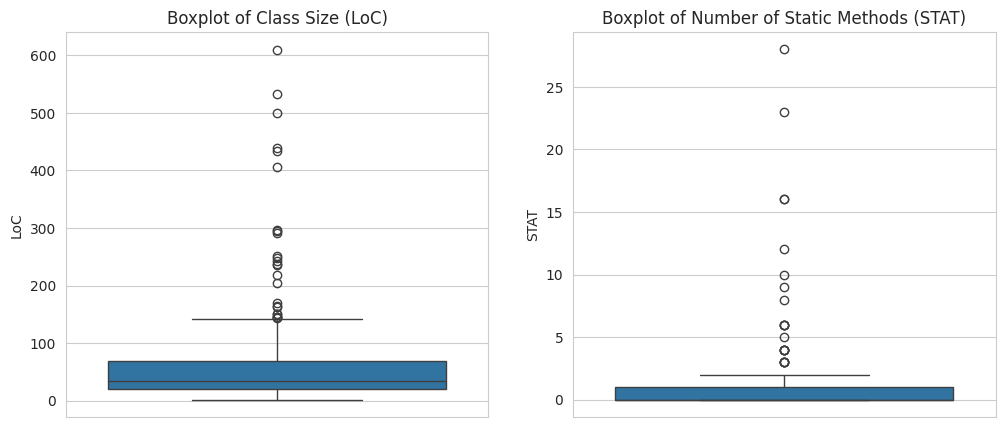

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(y=merged_df['LoC'], ax=axes[0])
axes[0].set_title("Boxplot of Class Size (LoC)")

sns.boxplot(y=merged_df['STAT'], ax=axes[1])
axes[1].set_title("Boxplot of Number of Static Methods (STAT)")

plt.show()


Compute Spearman's correlation

In [43]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(merged_df['LoC'], merged_df['STAT'])
print(f"Spearman correlation: {corr:.4f}, p-value: {p_value:.4f}")


Spearman correlation: 0.5106, p-value: 0.0000


We can conclude, that LoC and amount of static methods have a moderate positive correlation

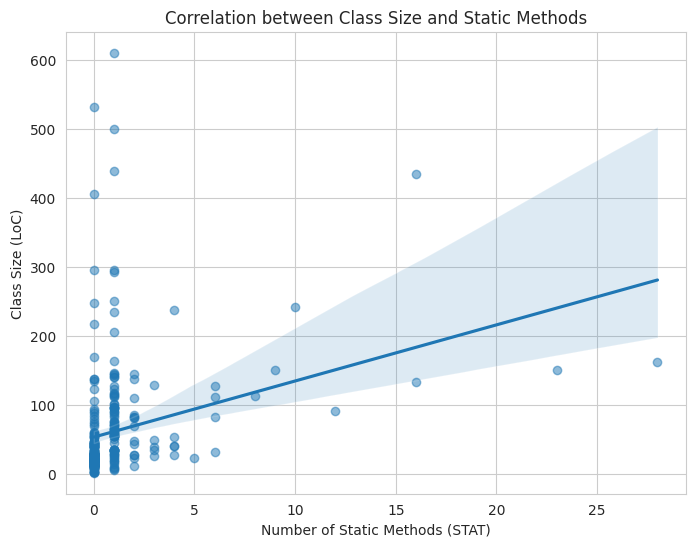

In [44]:
plt.figure(figsize=(8, 6))
sns.regplot(x=merged_df['STAT'], y=merged_df['LoC'], scatter_kws={'alpha': 0.5})
plt.xlabel("Number of Static Methods (STAT)")
plt.ylabel("Class Size (LoC)")
plt.title("Correlation between Class Size and Static Methods")
plt.show()


Our data follows log-normal distribution, so the log-normal regression is more suitable

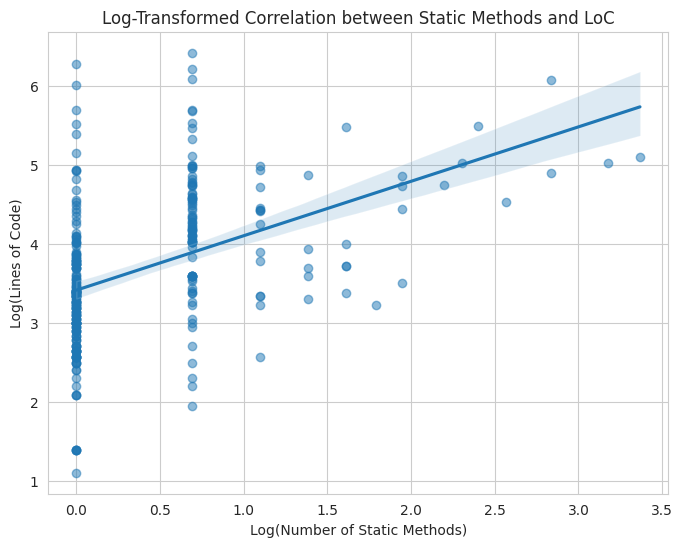

In [45]:
import numpy as np

# Apply log transformation
merged_df['log_STAT'] = np.log1p(merged_df['STAT'])  # log(1 + x) to handle zero values
merged_df['log_LoC'] = np.log1p(merged_df['LoC'])

# Scatter plot with regression on log-transformed data
plt.figure(figsize=(8, 6))
sns.regplot(x=merged_df['log_STAT'], y=merged_df['log_LoC'], scatter_kws={'alpha': 0.5})
plt.xlabel("Log(Number of Static Methods)")
plt.ylabel("Log(Lines of Code)")
plt.title("Log-Transformed Correlation between Static Methods and LoC")
plt.show()